# ** Fruit 360 **

We'll work with the [Fruit 360 dataset](https://www.kaggle.com/datasets/moltean/fruits) from Kaggle.

This is image data of fruits and vegetables. It contains around 90k images of size 100x100 distributed under 131 categories.
The Train and Test data is separated. There are around 68k images in Train and 23k in Test.

In [1]:
import os
import pathlib

from tqdm import tqdm
import cv2  

#from PIL import Image 

import numpy as np
from numpy import zeros, vstack
from numpy.random import random, rand, randint, randn
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

In [2]:
# Set the random seed
tf.random.set_seed(42)

# Import and preprocess the data

## Import the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! unzip "/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/Fruits 360 - 20 classes".zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: Training/Pomegranate/316_100.jpg  
  inflating: Training/Pomegranate/317_100.jpg  
  inflating: Training/Pomegranate/318_100.jpg  
  inflating: Training/Pomegranate/319_100.jpg  
  inflating: Training/Pomegranate/31_100.jpg  
  inflating: Training/Pomegranate/320_100.jpg  
  inflating: Training/Pomegranate/r_0_100.jpg  
  inflating: Training/Pomegranate/r_100_100.jpg  
  inflating: Training/Pomegranate/r_101_100.jpg  
  inflating: Training/Pomegranate/r_102_100.jpg  
  inflating: Training/Pomegranate/r_103_100.jpg  
  inflating: Training/Pomegranate/r_104_100.jpg  
  inflating: Training/Pomegranate/r_105_100.jpg  
  inflating: Training/Pomegranate/r_106_100.jpg  
  inflating: Training/Pomegranate/r_107_100.jpg  
  inflating: Training/Pomegranate/r_108_100.jpg  
  inflating: Training/Pomegranate/r_109_100.jpg  
  inflating: Training/Pomegranate/r_110_100.jpg  
  inflating: Training/Pomegranate/r_111_100.jpg  
  inflatin

> 🔑 **Note:** If you're using Google Colab and your runtime disconnects, you may have to redownload the files. You can do this by rerunning the cell above.

## Overview the data

In [5]:
!ls

drive  sample_data  Test  Training


In [6]:
!ls "Training"

'Apple Granny Smith'   Blueberry	   Guava       Orange	   Pomegranate
'Apple Red 1'	      'Cherry Wax Black'   Kiwi        Peach	   Quince
 Apricot	      'Grapefruit Pink'    Mandarine   Pear	   Strawberry
 Banana		      'Grape White'	   Mango       Pineapple   Watermelon


In [7]:
train_dir = "Training"
test_dir = "Test"

In [8]:
# Walk through train directory and list number of files
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 20 directories and 0 images in 'Training'.
There are 0 directories and 475 images in 'Training/Watermelon'.
There are 0 directories and 492 images in 'Training/Apple Red 1'.
There are 0 directories and 490 images in 'Training/Mango'.
There are 0 directories and 462 images in 'Training/Blueberry'.
There are 0 directories and 490 images in 'Training/Quince'.
There are 0 directories and 492 images in 'Training/Pear'.
There are 0 directories and 492 images in 'Training/Apricot'.
There are 0 directories and 479 images in 'Training/Orange'.
There are 0 directories and 490 images in 'Training/Mandarine'.
There are 0 directories and 492 images in 'Training/Strawberry'.
There are 0 directories and 492 images in 'Training/Peach'.
There are 0 directories and 490 images in 'Training/Grapefruit Pink'.
There are 0 directories and 492 images in 'Training/Cherry Wax Black'.
There are 0 directories and 466 images in 'Training/Kiwi'.
There are 0 directories and 490 images in 'Training/Guava'.


In [9]:
# Another way to find out how many images are in a file
num_specific_class_train = len(os.listdir(train_dir))
num_specific_class_train

20

In [10]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Apple Granny Smith' 'Apple Red 1' 'Apricot' 'Banana' 'Blueberry'
 'Cherry Wax Black' 'Grape White' 'Grapefruit Pink' 'Guava' 'Kiwi'
 'Mandarine' 'Mango' 'Orange' 'Peach' 'Pear' 'Pineapple' 'Pomegranate'
 'Quince' 'Strawberry' 'Watermelon']


In [11]:
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (100, 100)

## Load the data

In [12]:
def load_data():
    """
        Load the data:
            - 9,738 images to train the network.
            - 3,267 images to test how accurately the network learned to classify images.
    """
    
    datasets = [train_dir, test_dir]
    output = []

    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   

        output.append((images, labels))

    return output

In [13]:
(train_data, train_labels), (test_data, test_labels) = load_data()

Loading Training


100%|██████████| 492/492 [00:00<00:00, 3193.89it/s]


Loading Test


100%|██████████| 164/164 [00:00<00:00, 3879.02it/s]


In [14]:
train_data = train_data / 255.0
test_data = test_data / 255.0

In [15]:
tf.random.set_seed(42)
train_data, train_labels = shuffle(train_data, train_labels, random_state=427)

In [16]:
def prepare_Fruit360_data():
  (train_x, _), (_, _) = load_data()
  x = train_x.astype("float32") 
  x = (x - 127.5) / 127.5
  return x

In [17]:
dataset_1 = prepare_Fruit360_data()

Loading Training


100%|██████████| 492/492 [00:00<00:00, 3663.76it/s]


Loading Test


100%|██████████| 164/164 [00:00<00:00, 3210.79it/s]


## Analyze the data

In [18]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 9738
Number of testing examples: 3267
Each image is of size: (100, 100)


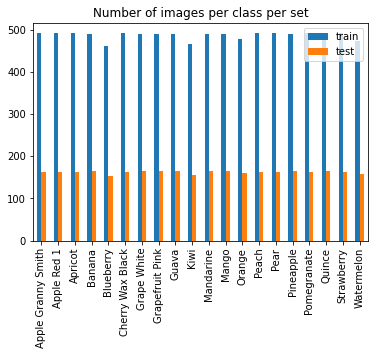

In [19]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.title("Number of images per class per set")
plt.show()

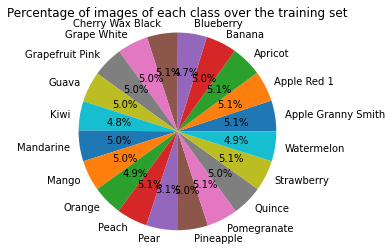

In [20]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Percentage of images of each class over the training set')
plt.show()

## Visualize the data 

In [21]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

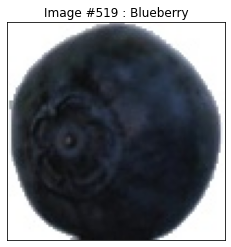

In [22]:
display_random_image(class_names, train_data, train_labels)

In [23]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[index]])
    plt.show()

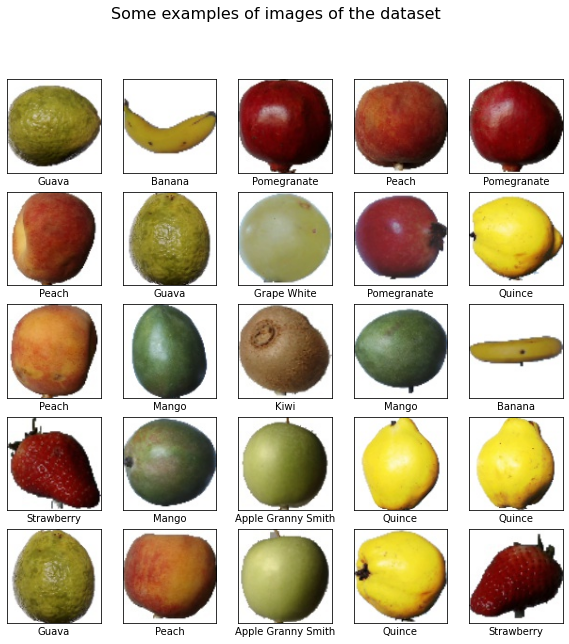

In [24]:
display_examples(class_names, train_data, train_labels)

# Complete GAN

In [ ]:
INPUT_TENSOR = (100, 100, 3)

def discriminator_model(input_shape=INPUT_TENSOR):
  model = Sequential([
  Conv2D(64,(3,3),padding="same",input_shape=input_shape),
  LeakyReLU(alpha=0.2),
  Conv2D(64,(3,3),strides=(2,2),padding="same"), # added later
  LeakyReLU(alpha=0.2),                          # added later
  Conv2D(128,(3,3),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),
  Conv2D(128,(3,3),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),
  Conv2D(256,(3,3),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),
  Flatten(), # flatten
  Dropout(0.4),
  Dense(60),            # added later
  LeakyReLU(alpha=0.2), # added later
  Dense(1,activation="sigmoid")
  ])

  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
  
  return model

In [ ]:
discriminator_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 100, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 50, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 25, 25, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       1

In [ ]:
def generate_real_samples(dataset, n_samples):
  index = randint(0, dataset.shape[0], n_samples)
  x = dataset[index]
  y = np.ones((n_samples,1))
  return x,y

In [ ]:
def generator_model(latent_dim):
  n_nodes = 32 * 25 * 25
  
  model = Sequential([
  Dense(n_nodes, input_dim = latent_dim),
  LeakyReLU(alpha=0.2),
  Reshape((25,25,32)),
  # upsample to 50x50
  Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),
  # upsample to 100x100
  Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),
  Conv2D(3,(5,5), activation="tanh",padding="same")
  ])

  return model

In [ ]:
generator_model(100).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20000)             2020000   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20000)             0         
                                                                 
 reshape (Reshape)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 128)      65664     
 nspose)                                                         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 50, 50, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 100, 100, 128)    262272    
 ranspose)                                            

In [25]:
def generate_latent_points(latent_dim, n_samples):
  x = randn(latent_dim * n_samples)
  x = x.reshape(n_samples,latent_dim)
  return x

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
  latent_points = generate_latent_points(latent_dim, n_samples)
  x_fake = generator.predict(latent_points)
  y = np.zeros((n_samples,1))
  return x_fake,y

1/1 [==============================] - 8s 8s/step


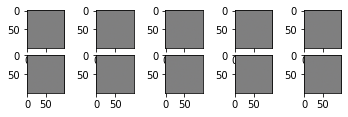

In [ ]:
# Generating fake samples from untrained generator
latent_dim = 100
generator_S = generator_model(100)
x, _ = generate_fake_samples(generator_S, latent_dim, 10)
x = (x+1)/2.0
for i in range(10):
  plt.subplot(5,5,1+i)
  plt.imshow(x[i])
plt.show()

In [ ]:
discriminator_S = discriminator_model()

In [ ]:
def gan_model(generator, discriminator):
  discriminator.trainable = False
  model = Sequential([
  generator,
  discriminator
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
  model.compile(loss="binary_crossentropy", optimizer = optimizer)
  
  return model

In [ ]:
gan_S = gan_model(generator_S, discriminator_S)
gan_S.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 100, 100, 3)       2357539   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 1308089   
                                                                 
Total params: 3,665,628
Trainable params: 2,357,539
Non-trainable params: 1,308,089
_________________________________________________________________


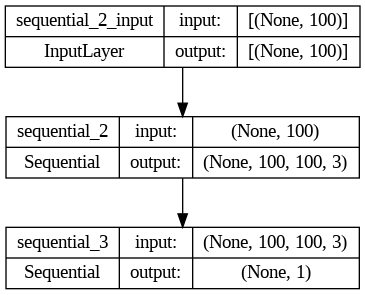

In [ ]:
# plot gan model
plot_model(gan_S, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def summarize_model_performance(epoch, generator, discriminator,dataset,latent_dim,n_samples=50):
  x_real, y_real = generate_real_samples(dataset,n_samples)
  _, real_accuracy = discriminator.train_on_batch(x_real, y_real)
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
  _, fake_accuracy = discriminator.train_on_batch(x_fake, y_fake)
  print("Real accuracy is " + str(real_accuracy) + " Fake accuracy is " + str(fake_accuracy))
  x_fake = (x_fake+1) / 2.0
  for j in range(5*5):
    plt.subplot(5,5,j+1)
    plt.axis("off")
    plt.imshow(x_fake[i])
  file_name = "/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/generator of similar images for Fruits 360/generated_plot_e%03d.png" % (epoch+1)
  plt.savefig(file_name)
  plt.close()
  model_name = "generator_of_similar_images_%03d_for_Fruits_360.h5" % (epoch+1)
  model_save_location = "/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/generator of similar images for Fruits 360/" + model_name
  generator.save(model_save_location)

In [ ]:
def train_gan(gan_model, generator, discriminator,latent_dim, dataset, n_epochs=100, n_batch=128):
  batches_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(batches_per_epoch):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1,_ = discriminator.train_on_batch(x_real,y_real)
      x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      d_loss2, _ = discriminator.train_on_batch(x_fake, y_fake)
      x_gan = generate_latent_points(latent_dim,n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print("Epoch "+ str(i+1) + " Batch " + str(j+1) + " Loss on real " + str(d_loss1) + " Loss on fake " + str(d_loss2))
    if (i+1) %5 == 0 :
      summarize_model_performance(i, generator, discriminator, dataset, latent_dim)

In [ ]:
train_gan(gan_S, generator_S, discriminator_S, latent_dim, dataset_1)

2/2 [==============================] - 1s 8ms/step
Epoch 1 Batch 1 Loss on real 0.6763882637023926 Loss on fake 0.6968015432357788
2/2 [==============================] - 0s 25ms/step
Epoch 1 Batch 2 Loss on real 0.5064473748207092 Loss on fake 0.6995794773101807
2/2 [==============================] - 0s 25ms/step
Epoch 1 Batch 3 Loss on real 0.29441016912460327 Loss on fake 0.708667516708374
2/2 [==============================] - 0s 25ms/step
Epoch 1 Batch 4 Loss on real 0.08522485196590424 Loss on fake 0.7229028940200806
2/2 [==============================] - 0s 25ms/step
Epoch 1 Batch 5 Loss on real 0.022312220185995102 Loss on fake 0.7286153435707092
2/2 [==============================] - 0s 25ms/step
Epoch 1 Batch 6 Loss on real 0.011777764186263084 Loss on fake 0.711686372756958
2/2 [==============================] - 0s 25ms/step
Epoch 1 Batch 7 Loss on real 0.008531816303730011 Loss on fake 0.6811091899871826
2/2 [==============================] - 0s 26ms/step
Epoch 1 Batch 8 Los

2/2 [==============================] - 0s 36ms/step
Epoch 6 Batch 1 Loss on real 0.3400900959968567 Loss on fake 0.3350106477737427
2/2 [==============================] - 0s 25ms/step
Epoch 6 Batch 2 Loss on real 0.49203410744667053 Loss on fake 0.29569876194000244
2/2 [==============================] - 0s 25ms/step
Epoch 6 Batch 3 Loss on real 0.44834113121032715 Loss on fake 0.39135655760765076
2/2 [==============================] - 0s 25ms/step
Epoch 6 Batch 4 Loss on real 0.34912580251693726 Loss on fake 0.45883846282958984
2/2 [==============================] - 0s 25ms/step
Epoch 6 Batch 5 Loss on real 0.36787232756614685 Loss on fake 0.16427923738956451
2/2 [==============================] - 0s 25ms/step
Epoch 6 Batch 6 Loss on real 0.2673724293708801 Loss on fake 0.5498714447021484
2/2 [==============================] - 0s 25ms/step
Epoch 6 Batch 7 Loss on real 0.5496302843093872 Loss on fake 0.24121028184890747
2/2 [==============================] - 0s 25ms/step
Epoch 6 Batch 8

2/2 [==============================] - 0s 38ms/step
Epoch 11 Batch 1 Loss on real 0.5425379872322083 Loss on fake 0.4547376036643982
2/2 [==============================] - 0s 25ms/step
Epoch 11 Batch 2 Loss on real 0.2954007387161255 Loss on fake 0.29638880491256714
2/2 [==============================] - 0s 25ms/step
Epoch 11 Batch 3 Loss on real 0.39381489157676697 Loss on fake 0.2800801992416382
2/2 [==============================] - 0s 25ms/step
Epoch 11 Batch 4 Loss on real 0.2667868733406067 Loss on fake 0.4104667901992798
2/2 [==============================] - 0s 25ms/step
Epoch 11 Batch 5 Loss on real 0.6103920936584473 Loss on fake 0.5093744397163391
2/2 [==============================] - 0s 25ms/step
Epoch 11 Batch 6 Loss on real 0.44607114791870117 Loss on fake 0.23009257018566132
2/2 [==============================] - 0s 25ms/step
Epoch 11 Batch 7 Loss on real 0.3777889907360077 Loss on fake 0.4731750190258026
2/2 [==============================] - 0s 25ms/step
Epoch 11 Batc

2/2 [==============================] - 0s 36ms/step
Epoch 16 Batch 1 Loss on real 0.6751540303230286 Loss on fake 0.6044752597808838
2/2 [==============================] - 0s 25ms/step
Epoch 16 Batch 2 Loss on real 0.46911191940307617 Loss on fake 0.5106439590454102
2/2 [==============================] - 0s 25ms/step
Epoch 16 Batch 3 Loss on real 0.49321407079696655 Loss on fake 0.4512742757797241
2/2 [==============================] - 0s 25ms/step
Epoch 16 Batch 4 Loss on real 0.5788595676422119 Loss on fake 0.5915002822875977
2/2 [==============================] - 0s 25ms/step
Epoch 16 Batch 5 Loss on real 0.4871912896633148 Loss on fake 0.5062475204467773
2/2 [==============================] - 0s 25ms/step
Epoch 16 Batch 6 Loss on real 0.5065333247184753 Loss on fake 0.37040644884109497
2/2 [==============================] - 0s 25ms/step
Epoch 16 Batch 7 Loss on real 0.5424107313156128 Loss on fake 0.5949209928512573
2/2 [==============================] - 0s 25ms/step
Epoch 16 Batch

2/2 [==============================] - 0s 36ms/step
Epoch 21 Batch 1 Loss on real 0.4918757677078247 Loss on fake 0.346025288105011
2/2 [==============================] - 0s 25ms/step
Epoch 21 Batch 2 Loss on real 0.34108197689056396 Loss on fake 0.4598580598831177
2/2 [==============================] - 0s 25ms/step
Epoch 21 Batch 3 Loss on real 0.3460392355918884 Loss on fake 0.2817315459251404
2/2 [==============================] - 0s 20ms/step
Epoch 21 Batch 4 Loss on real 0.3993125557899475 Loss on fake 0.3676441013813019
2/2 [==============================] - 0s 25ms/step
Epoch 21 Batch 5 Loss on real 0.30616486072540283 Loss on fake 0.3304620087146759
2/2 [==============================] - 0s 21ms/step
Epoch 21 Batch 6 Loss on real 0.4074033498764038 Loss on fake 0.43483424186706543
2/2 [==============================] - 0s 25ms/step
Epoch 21 Batch 7 Loss on real 0.5016833543777466 Loss on fake 0.42730048298835754
2/2 [==============================] - 0s 25ms/step
Epoch 21 Batch

2/2 [==============================] - 0s 36ms/step
Epoch 26 Batch 1 Loss on real 0.33081936836242676 Loss on fake 0.268246591091156
2/2 [==============================] - 0s 25ms/step
Epoch 26 Batch 2 Loss on real 0.42855316400527954 Loss on fake 0.3391205370426178
2/2 [==============================] - 0s 25ms/step
Epoch 26 Batch 3 Loss on real 0.4776516258716583 Loss on fake 0.42468225955963135
2/2 [==============================] - 0s 25ms/step
Epoch 26 Batch 4 Loss on real 0.43686333298683167 Loss on fake 0.7141449451446533
2/2 [==============================] - 0s 25ms/step
Epoch 26 Batch 5 Loss on real 0.4373072385787964 Loss on fake 0.21852633357048035
2/2 [==============================] - 0s 25ms/step
Epoch 26 Batch 6 Loss on real 0.36176037788391113 Loss on fake 0.28914403915405273
2/2 [==============================] - 0s 25ms/step
Epoch 26 Batch 7 Loss on real 0.3662480115890503 Loss on fake 0.30361148715019226
2/2 [==============================] - 0s 25ms/step
Epoch 26 B

2/2 [==============================] - 0s 37ms/step
Epoch 31 Batch 1 Loss on real 0.39972540736198425 Loss on fake 0.17933569848537445
2/2 [==============================] - 0s 25ms/step
Epoch 31 Batch 2 Loss on real 0.24147014319896698 Loss on fake 0.5061269998550415
2/2 [==============================] - 0s 25ms/step
Epoch 31 Batch 3 Loss on real 0.44903993606567383 Loss on fake 0.2592143714427948
2/2 [==============================] - 0s 25ms/step
Epoch 31 Batch 4 Loss on real 0.3032696843147278 Loss on fake 0.22632542252540588
2/2 [==============================] - 0s 25ms/step
Epoch 31 Batch 5 Loss on real 0.3085390329360962 Loss on fake 0.3156379759311676
2/2 [==============================] - 0s 25ms/step
Epoch 31 Batch 6 Loss on real 0.28875407576560974 Loss on fake 0.24794504046440125
2/2 [==============================] - 0s 25ms/step
Epoch 31 Batch 7 Loss on real 0.23369261622428894 Loss on fake 0.17820098996162415
2/2 [==============================] - 0s 25ms/step
Epoch 31

2/2 [==============================] - 0s 36ms/step
Epoch 36 Batch 1 Loss on real 0.39219793677330017 Loss on fake 0.12172199785709381
2/2 [==============================] - 0s 25ms/step
Epoch 36 Batch 2 Loss on real 0.25184130668640137 Loss on fake 0.22368022799491882
2/2 [==============================] - 0s 25ms/step
Epoch 36 Batch 3 Loss on real 0.1443396359682083 Loss on fake 0.21696458756923676
2/2 [==============================] - 0s 25ms/step
Epoch 36 Batch 4 Loss on real 0.22453734278678894 Loss on fake 0.2316788136959076
2/2 [==============================] - 0s 25ms/step
Epoch 36 Batch 5 Loss on real 0.23780658841133118 Loss on fake 0.1948133409023285
2/2 [==============================] - 0s 25ms/step
Epoch 36 Batch 6 Loss on real 0.41500234603881836 Loss on fake 0.21547913551330566
2/2 [==============================] - 0s 29ms/step
Epoch 36 Batch 7 Loss on real 0.2003600299358368 Loss on fake 0.3125610947608948
2/2 [==============================] - 0s 25ms/step
Epoch 36

2/2 [==============================] - 0s 36ms/step
Epoch 41 Batch 1 Loss on real 0.14406391978263855 Loss on fake 0.12282567471265793
2/2 [==============================] - 0s 25ms/step
Epoch 41 Batch 2 Loss on real 0.2977776527404785 Loss on fake 0.22371584177017212
2/2 [==============================] - 0s 25ms/step
Epoch 41 Batch 3 Loss on real 0.08094880729913712 Loss on fake 0.2885829210281372
2/2 [==============================] - 0s 25ms/step
Epoch 41 Batch 4 Loss on real 0.26912063360214233 Loss on fake 0.10589716583490372
2/2 [==============================] - 0s 26ms/step
Epoch 41 Batch 5 Loss on real 0.1925501823425293 Loss on fake 0.07883459329605103
2/2 [==============================] - 0s 25ms/step
Epoch 41 Batch 6 Loss on real 0.2371126413345337 Loss on fake 0.26786965131759644
2/2 [==============================] - 0s 25ms/step
Epoch 41 Batch 7 Loss on real 0.19689227640628815 Loss on fake 0.11424458026885986
2/2 [==============================] - 0s 25ms/step
Epoch 4

2/2 [==============================] - 0s 36ms/step
Epoch 46 Batch 1 Loss on real 0.09820424020290375 Loss on fake 0.2148837447166443
2/2 [==============================] - 0s 25ms/step
Epoch 46 Batch 2 Loss on real 0.46082159876823425 Loss on fake 0.10824461281299591
2/2 [==============================] - 0s 25ms/step
Epoch 46 Batch 3 Loss on real 0.3683406412601471 Loss on fake 0.27216553688049316
2/2 [==============================] - 0s 25ms/step
Epoch 46 Batch 4 Loss on real 0.08034330606460571 Loss on fake 0.27829426527023315
2/2 [==============================] - 0s 25ms/step
Epoch 46 Batch 5 Loss on real 0.41438165307044983 Loss on fake 0.1488969326019287
2/2 [==============================] - 0s 25ms/step
Epoch 46 Batch 6 Loss on real 0.4953092932701111 Loss on fake 0.33658239245414734
2/2 [==============================] - 0s 25ms/step
Epoch 46 Batch 7 Loss on real 0.24625304341316223 Loss on fake 0.1622101366519928
2/2 [==============================] - 0s 25ms/step
Epoch 46

2/2 [==============================] - 0s 36ms/step
Epoch 51 Batch 1 Loss on real 0.18824148178100586 Loss on fake 0.19936203956604004
2/2 [==============================] - 0s 25ms/step
Epoch 51 Batch 2 Loss on real 0.23430845141410828 Loss on fake 0.14036664366722107
2/2 [==============================] - 0s 25ms/step
Epoch 51 Batch 3 Loss on real 0.14548954367637634 Loss on fake 0.1941431164741516
2/2 [==============================] - 0s 25ms/step
Epoch 51 Batch 4 Loss on real 0.042973168194293976 Loss on fake 0.056344449520111084
2/2 [==============================] - 0s 25ms/step
Epoch 51 Batch 5 Loss on real 0.24456100165843964 Loss on fake 0.07796409726142883
2/2 [==============================] - 0s 25ms/step
Epoch 51 Batch 6 Loss on real 0.085121288895607 Loss on fake 0.2457447201013565
2/2 [==============================] - 0s 25ms/step
Epoch 51 Batch 7 Loss on real 0.14234812557697296 Loss on fake 0.05242667719721794
2/2 [==============================] - 0s 25ms/step
Epoch

2/2 [==============================] - 0s 36ms/step
Epoch 56 Batch 1 Loss on real 0.1025819480419159 Loss on fake 0.10706494003534317
2/2 [==============================] - 0s 25ms/step
Epoch 56 Batch 2 Loss on real 0.22921478748321533 Loss on fake 0.027485324069857597
2/2 [==============================] - 0s 25ms/step
Epoch 56 Batch 3 Loss on real 0.11860570311546326 Loss on fake 0.2412327527999878
2/2 [==============================] - 0s 25ms/step
Epoch 56 Batch 4 Loss on real 0.08704674243927002 Loss on fake 0.06404782831668854
2/2 [==============================] - 0s 25ms/step
Epoch 56 Batch 5 Loss on real 0.21248777210712433 Loss on fake 0.03447195887565613
2/2 [==============================] - 0s 25ms/step
Epoch 56 Batch 6 Loss on real 0.10062770545482635 Loss on fake 0.22640454769134521
2/2 [==============================] - 0s 25ms/step
Epoch 56 Batch 7 Loss on real 0.07689853012561798 Loss on fake 0.05007949844002724
2/2 [==============================] - 0s 25ms/step
Epoc

2/2 [==============================] - 0s 36ms/step
Epoch 61 Batch 1 Loss on real 0.13022057712078094 Loss on fake 0.06005708873271942
2/2 [==============================] - 0s 25ms/step
Epoch 61 Batch 2 Loss on real 0.06972438097000122 Loss on fake 0.041791222989559174
2/2 [==============================] - 0s 25ms/step
Epoch 61 Batch 3 Loss on real 0.10857822746038437 Loss on fake 0.07239013910293579
2/2 [==============================] - 0s 25ms/step
Epoch 61 Batch 4 Loss on real 0.12990498542785645 Loss on fake 0.10439076274633408
2/2 [==============================] - 0s 25ms/step
Epoch 61 Batch 5 Loss on real 0.08983214199542999 Loss on fake 0.1632840633392334
2/2 [==============================] - 0s 25ms/step
Epoch 61 Batch 6 Loss on real 0.12161486595869064 Loss on fake 0.04734449461102486
2/2 [==============================] - 0s 25ms/step
Epoch 61 Batch 7 Loss on real 0.13278983533382416 Loss on fake 0.0973128080368042
2/2 [==============================] - 0s 25ms/step
Epoc

2/2 [==============================] - 0s 35ms/step
Epoch 66 Batch 1 Loss on real 0.03225844353437424 Loss on fake 0.041194044053554535
2/2 [==============================] - 0s 25ms/step
Epoch 66 Batch 2 Loss on real 0.04927590861916542 Loss on fake 0.09443871676921844
2/2 [==============================] - 0s 25ms/step
Epoch 66 Batch 3 Loss on real 0.08532074093818665 Loss on fake 0.03891274333000183
2/2 [==============================] - 0s 25ms/step
Epoch 66 Batch 4 Loss on real 0.06888826191425323 Loss on fake 0.0980026051402092
2/2 [==============================] - 0s 25ms/step
Epoch 66 Batch 5 Loss on real 0.07383152842521667 Loss on fake 0.034983959048986435
2/2 [==============================] - 0s 25ms/step
Epoch 66 Batch 6 Loss on real 0.05612757056951523 Loss on fake 0.1737460196018219
2/2 [==============================] - 0s 26ms/step
Epoch 66 Batch 7 Loss on real 0.28816407918930054 Loss on fake 0.019940892234444618
2/2 [==============================] - 0s 26ms/step
Ep

2/2 [==============================] - 0s 36ms/step
Epoch 71 Batch 1 Loss on real 0.13423025608062744 Loss on fake 0.1136341542005539
2/2 [==============================] - 0s 25ms/step
Epoch 71 Batch 2 Loss on real 0.18833279609680176 Loss on fake 0.05673225224018097
2/2 [==============================] - 0s 25ms/step
Epoch 71 Batch 3 Loss on real 0.031077351421117783 Loss on fake 0.11136848479509354
2/2 [==============================] - 0s 25ms/step
Epoch 71 Batch 4 Loss on real 0.01696000061929226 Loss on fake 0.022782493382692337
2/2 [==============================] - 0s 25ms/step
Epoch 71 Batch 5 Loss on real 0.1277758628129959 Loss on fake 0.014916242100298405
2/2 [==============================] - 0s 25ms/step
Epoch 71 Batch 6 Loss on real 0.05578754469752312 Loss on fake 0.07458231598138809
2/2 [==============================] - 0s 25ms/step
Epoch 71 Batch 7 Loss on real 0.03337571397423744 Loss on fake 0.02557242102921009
2/2 [==============================] - 0s 25ms/step
Ep

2/2 [==============================] - 0s 36ms/step
Epoch 76 Batch 1 Loss on real 0.13015413284301758 Loss on fake 0.04114428907632828
2/2 [==============================] - 0s 25ms/step
Epoch 76 Batch 2 Loss on real 0.1349780410528183 Loss on fake 0.058851659297943115
2/2 [==============================] - 0s 25ms/step
Epoch 76 Batch 3 Loss on real 0.06845496594905853 Loss on fake 0.127363920211792
2/2 [==============================] - 0s 25ms/step
Epoch 76 Batch 4 Loss on real 0.07102176547050476 Loss on fake 0.07319345325231552
2/2 [==============================] - 0s 25ms/step
Epoch 76 Batch 5 Loss on real 0.13947497308254242 Loss on fake 0.10436102747917175
2/2 [==============================] - 0s 25ms/step
Epoch 76 Batch 6 Loss on real 0.1398538053035736 Loss on fake 0.07996182143688202
2/2 [==============================] - 0s 25ms/step
Epoch 76 Batch 7 Loss on real 0.024657562375068665 Loss on fake 0.10481315106153488
2/2 [==============================] - 0s 25ms/step
Epoch

2/2 [==============================] - 0s 37ms/step
Epoch 81 Batch 1 Loss on real 0.10404866933822632 Loss on fake 0.050890155136585236
2/2 [==============================] - 0s 25ms/step
Epoch 81 Batch 2 Loss on real 0.011763188056647778 Loss on fake 0.1649474799633026
2/2 [==============================] - 0s 25ms/step
Epoch 81 Batch 3 Loss on real 0.05079780891537666 Loss on fake 0.026234030723571777
2/2 [==============================] - 0s 25ms/step
Epoch 81 Batch 4 Loss on real 0.10476809740066528 Loss on fake 0.04551180079579353
2/2 [==============================] - 0s 25ms/step
Epoch 81 Batch 5 Loss on real 0.10839393734931946 Loss on fake 0.12618844211101532
2/2 [==============================] - 0s 26ms/step
Epoch 81 Batch 6 Loss on real 0.08182065933942795 Loss on fake 0.08290144801139832
2/2 [==============================] - 0s 25ms/step
Epoch 81 Batch 7 Loss on real 0.08649174124002457 Loss on fake 0.041852232068777084
2/2 [==============================] - 0s 25ms/step


2/2 [==============================] - 0s 36ms/step
Epoch 86 Batch 1 Loss on real 0.07960867136716843 Loss on fake 0.021957777440547943
2/2 [==============================] - 0s 25ms/step
Epoch 86 Batch 2 Loss on real 0.029241422191262245 Loss on fake 0.037646468728780746
2/2 [==============================] - 0s 25ms/step
Epoch 86 Batch 3 Loss on real 0.03443090245127678 Loss on fake 0.039519358426332474
2/2 [==============================] - 0s 25ms/step
Epoch 86 Batch 4 Loss on real 0.12209853529930115 Loss on fake 0.032121699303388596
2/2 [==============================] - 0s 25ms/step
Epoch 86 Batch 5 Loss on real 0.08148843050003052 Loss on fake 0.06256420165300369
2/2 [==============================] - 0s 25ms/step
Epoch 86 Batch 6 Loss on real 0.00929109938442707 Loss on fake 0.0767553299665451
2/2 [==============================] - 0s 25ms/step
Epoch 86 Batch 7 Loss on real 0.17244073748588562 Loss on fake 0.1079612597823143
2/2 [==============================] - 0s 26ms/step


2/2 [==============================] - 0s 37ms/step
Epoch 91 Batch 1 Loss on real 0.190697580575943 Loss on fake 0.003709085052832961
2/2 [==============================] - 0s 25ms/step
Epoch 91 Batch 2 Loss on real 0.3452219069004059 Loss on fake 0.03435426950454712
2/2 [==============================] - 0s 25ms/step
Epoch 91 Batch 3 Loss on real 0.020863451063632965 Loss on fake 0.04723695293068886
2/2 [==============================] - 0s 26ms/step
Epoch 91 Batch 4 Loss on real 0.008976979181170464 Loss on fake 0.03624327480792999
2/2 [==============================] - 0s 26ms/step
Epoch 91 Batch 5 Loss on real 0.03607332333922386 Loss on fake 0.12747712433338165
2/2 [==============================] - 0s 26ms/step
Epoch 91 Batch 6 Loss on real 0.07783620059490204 Loss on fake 0.01726531982421875
2/2 [==============================] - 0s 25ms/step
Epoch 91 Batch 7 Loss on real 0.10022102296352386 Loss on fake 0.042200103402137756
2/2 [==============================] - 0s 25ms/step
Ep

2/2 [==============================] - 0s 35ms/step
Epoch 96 Batch 1 Loss on real 0.03356378152966499 Loss on fake 0.021542932838201523
2/2 [==============================] - 0s 25ms/step
Epoch 96 Batch 2 Loss on real 0.01889648474752903 Loss on fake 0.020021066069602966
2/2 [==============================] - 0s 25ms/step
Epoch 96 Batch 3 Loss on real 0.006888698786497116 Loss on fake 0.024109873920679092
2/2 [==============================] - 0s 25ms/step
Epoch 96 Batch 4 Loss on real 0.042409732937812805 Loss on fake 0.009643172845244408
2/2 [==============================] - 0s 25ms/step
Epoch 96 Batch 5 Loss on real 0.04559844732284546 Loss on fake 0.022905029356479645
2/2 [==============================] - 0s 25ms/step
Epoch 96 Batch 6 Loss on real 0.06284578144550323 Loss on fake 0.04206771031022072
2/2 [==============================] - 0s 29ms/step
Epoch 96 Batch 7 Loss on real 0.002333234064280987 Loss on fake 0.07771692425012589
2/2 [==============================] - 0s 25ms/

# Load GAN and generate images

1/1 [==============================] - 2s 2s/step


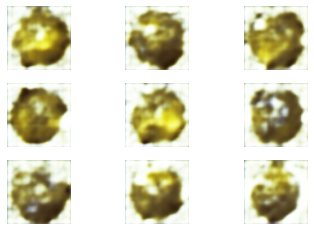

1/1 [==============================] - 2s 2s/step


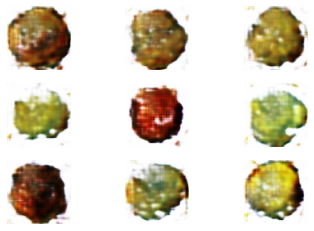

1/1 [==============================] - 1s 1s/step


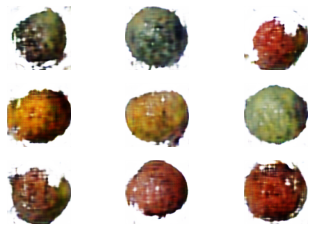

1/1 [==============================] - 2s 2s/step


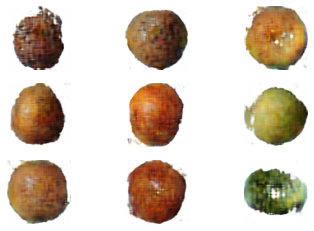

1/1 [==============================] - 2s 2s/step


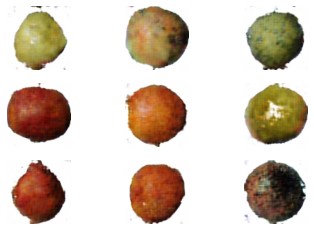

1/1 [==============================] - 1s 1s/step


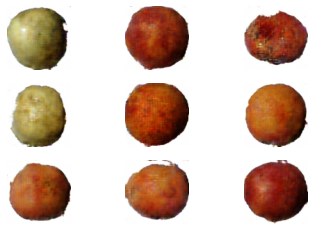

1/1 [==============================] - 1s 1s/step


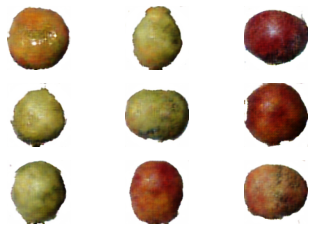

1/1 [==============================] - 3s 3s/step


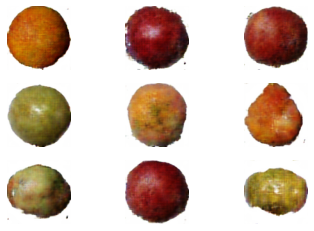

1/1 [==============================] - 1s 1s/step


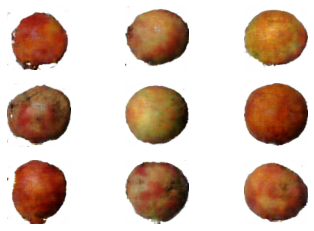

1/1 [==============================] - 2s 2s/step


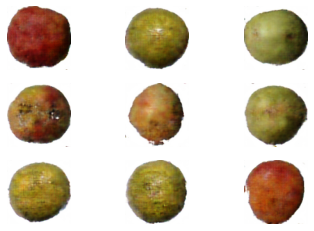

1/1 [==============================] - 2s 2s/step


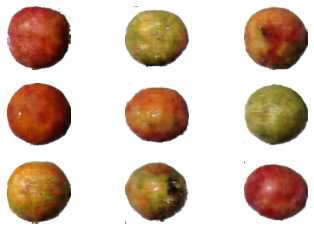

1/1 [==============================] - 2s 2s/step


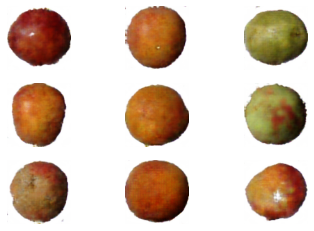

1/1 [==============================] - 1s 1s/step


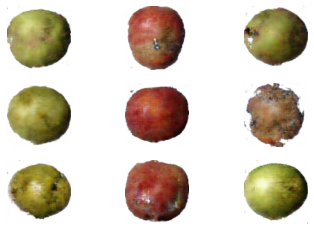

1/1 [==============================] - 2s 2s/step


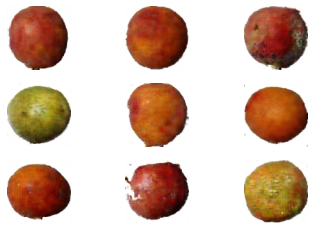

1/1 [==============================] - 2s 2s/step


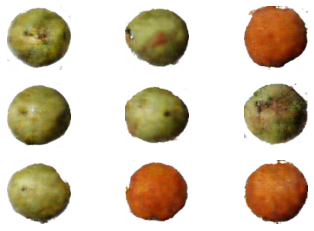

1/1 [==============================] - 2s 2s/step


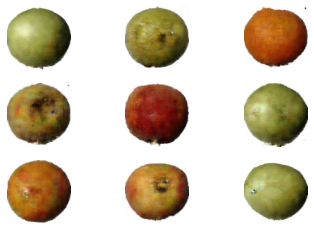

1/1 [==============================] - 2s 2s/step


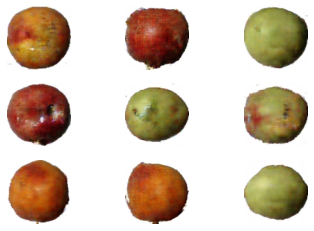

1/1 [==============================] - 2s 2s/step


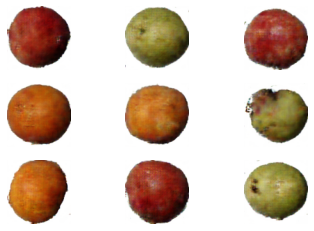

1/1 [==============================] - 2s 2s/step


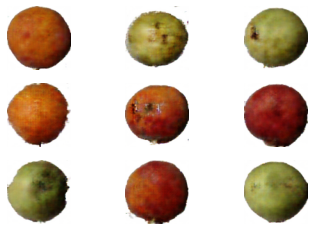

1/1 [==============================] - 2s 2s/step


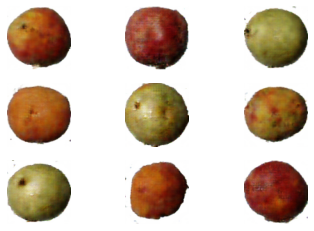

In [26]:
for i in range(100):
  if (i+1) %5 == 0:
    model_name = "generator_of_similar_images_%03d_for_Fruits_360.h5" % (i+1)
    model_save_location = "/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/generator of similar images for Fruits 360/" + model_name
    generator_S = load_model(model_save_location)
    latent_points = generate_latent_points(100,25)
    x = generator_S.predict(latent_points)
    x = (x+1) / 2.0
    for j in range(3*3):
      plt.subplot(3,3,j+1)
      plt.axis("off")
      plt.imshow(x[j,:,:])
    plt.show()

# Load classifier and classify the GAN's images

In [27]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/classifier of images for Fruits 360/classifier_of_images_for_Fruits_360.h5")

1/1 [==============================] - 0s 165ms/step


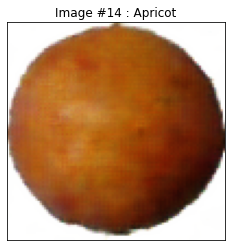

In [28]:
predictions = model.predict(x)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, x, pred_labels)

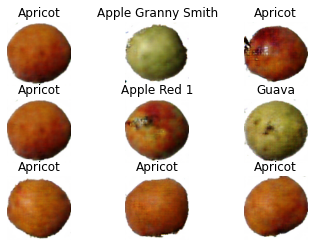

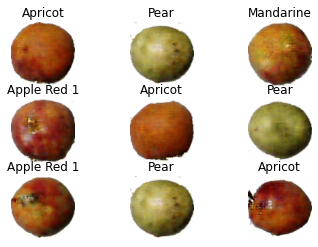

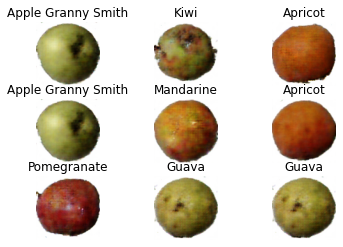

In [35]:
for i in range(3):
  for j in range(3*3):
    plt.subplot(3,3,j+1)
    plt.axis("off")
    index = np.random.randint(x.shape[0])
    plt.imshow(x[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[pred_labels[index]])
  plt.show()